In [2]:
import pandas as pd

# Load Data
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Overview
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

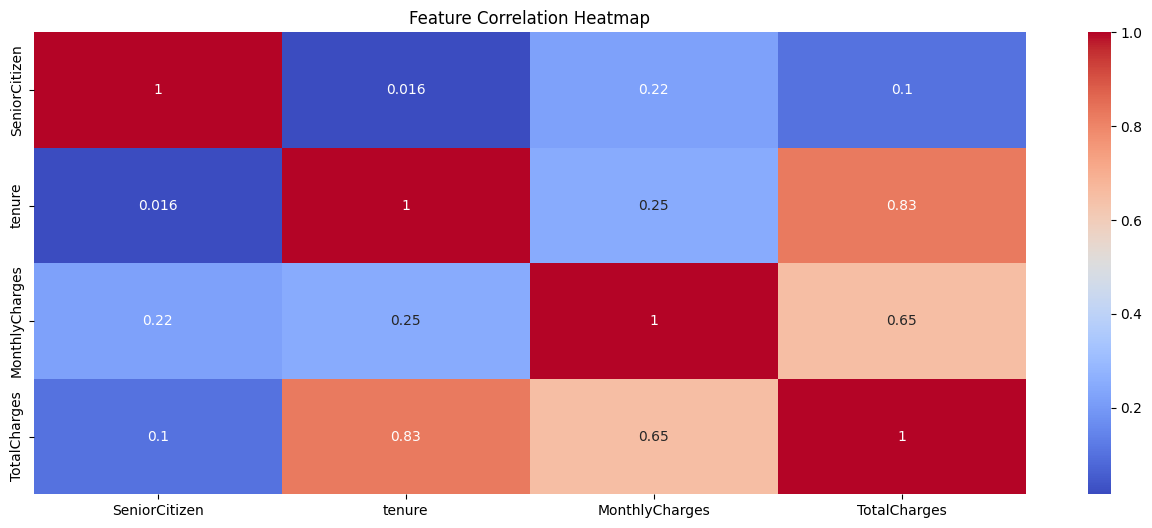

In [5]:
## Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-numeric columns for correlation computation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute and visualize the correlation matrix
plt.figure(figsize=(16, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


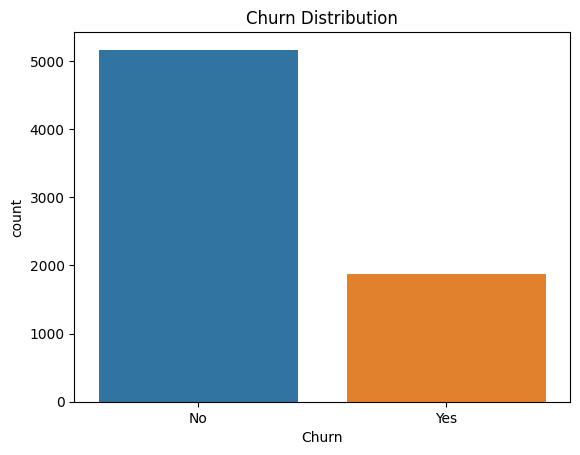

In [6]:
# Churn Distribution
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

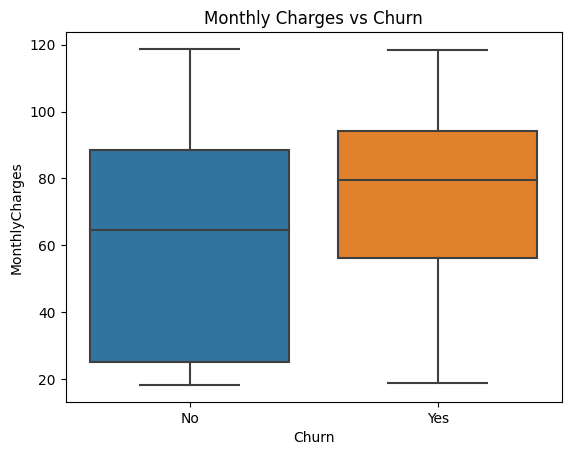

In [7]:
# Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

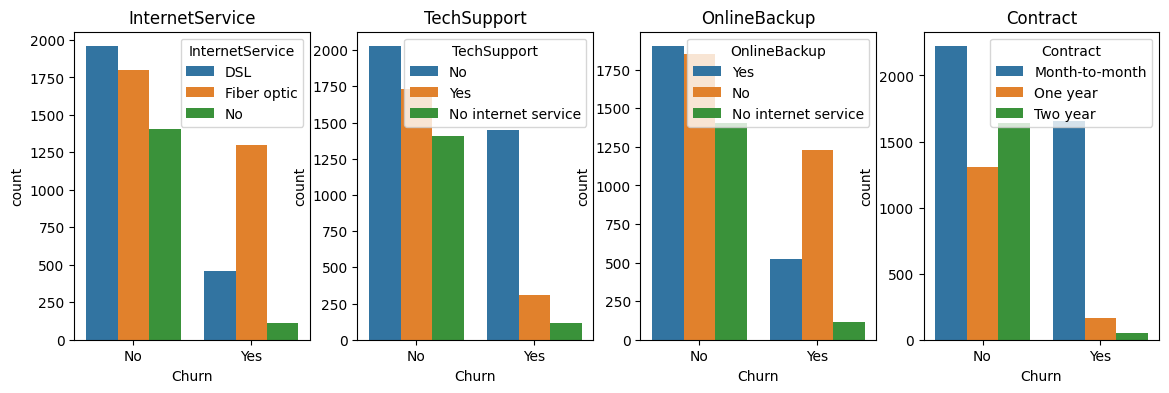

In [9]:
# Relationship between customer churn and categorical variables present in the dataset

cols = ['InternetService',"TechSupport","OnlineBackup","Contract"]

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    ax = plt.subplot(1, len(cols), i+1)
    sns.countplot(x ="Churn", hue = str(col), data = df)
    ax.set_title(f"{col}")

In [14]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Encoding Categorical Variables
cat_features = df.select_dtypes(include=['object']).drop(['customerID'], axis=1)
if 'Churn' in cat_features.columns:
    cat_features = cat_features.drop(['Churn'], axis=1)

le = LabelEncoder()
df_cat = cat_features.apply(le.fit_transform)

num_features = df[['tenure', 'TotalCharges', 'MonthlyCharges', 'SeniorCitizen']]

# Ensure 'Churn' is encoded as numeric
df['Churn'] = le.fit_transform(df['Churn'])

# Combine numeric and categorical features
finaldf = pd.concat([num_features, df_cat, df['Churn']], axis=1)

In [15]:
# Splitting Data

X = finaldf.drop(['Churn'], axis=1)
y = finaldf['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [17]:
from imblearn.over_sampling import SMOTE

# Oversampling with SMOTE

oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [18]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Model Building and Cross-Validation

rf = RandomForestClassifier(random_state=46)
cross_val_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(cross_val_scores):.2f}")

Cross-validation accuracy: 0.84


In [22]:
# Hyperparameter Tuning

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
gs = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=46),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [23]:
# Best Model
best_rf = gs.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=46)

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predictions
rf_preds = best_rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.7750969409737182
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1711
           1       0.56      0.63      0.60       610

    accuracy                           0.78      2321
   macro avg       0.71      0.73      0.72      2321
weighted avg       0.78      0.78      0.78      2321



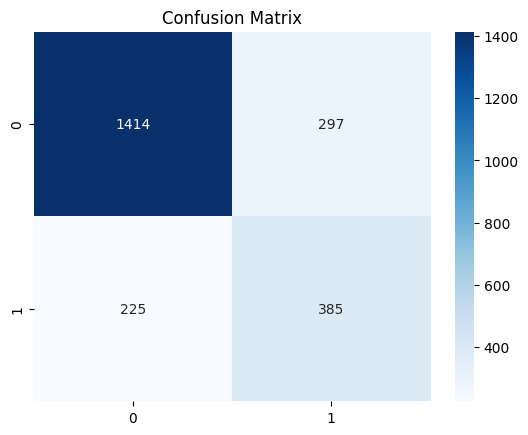

In [26]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

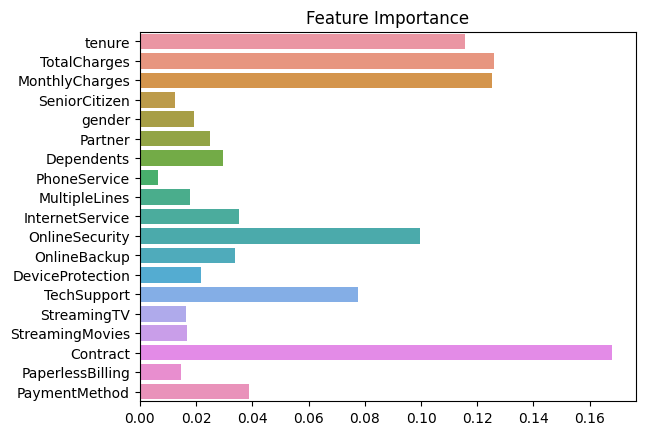

In [27]:
# Feature Importance
importances = best_rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()

In [28]:
from xgboost import XGBClassifier

# XGBoost Model
df_xgb = XGBClassifier(random_state=42)
df_xgb.fit(X_train, y_train)
xgb_preds = df_xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

XGBoost Accuracy: 0.7664799655320982
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1711
           1       0.55      0.59      0.57       610

    accuracy                           0.77      2321
   macro avg       0.70      0.71      0.70      2321
weighted avg       0.77      0.77      0.77      2321



In [29]:
# Overfitting Check
train_accuracy = accuracy_score(y_train, best_rf.predict(X_train))
test_accuracy = accuracy_score(y_test, rf_preds)
print(f"Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")

Train Accuracy: 0.97, Test Accuracy: 0.78
